# Evaluation notebook

This notebook is for evaluating trained models, and manipulating/combining their probabilities. The first couple cells set up the packages

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext tensorboard
#%matplotlib qt

In [2]:
# This is a blanket include statement cell, some of these may not be used in this notebook specifically

import os
from datetime import datetime
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import SimpleITK as sitk
#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
from collections import OrderedDict
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

import scipy

import torchmetrics

#import initial_ml as iml
from gbm_project import data_prep as dp
from gbm_project.pytorch.run_model_torch import RunModel
from gbm_project.pytorch import resnet_spottune as rs
from MedicalNet.models import resnet


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"using {device} device")
#torch.backends.cudnn.benchmark = False
#torch.use_deterministic_algorithms(True)

using cuda device


## Making probability pickles
The following cell take the trainings with logs specified in temperature_test_cfg.py and creates pickles of the probability evaluations. The entries in temperature_test_cfg.py are seperated by training, and the logs with each entry correspond to the 5 folds from the cross-validation splitting

In [ ]:
#directory that contains the dataset csvs
csv_dir = '../../data/upenn_GBM/csvs/radiomic_features_CaPTk/'

#The directory that points to the location of the npy directories
mod_image_dir = '../../data/upenn_GBM'

# will run over the 5-fold models specified in temp_ids
# temp_ids is a dictionary of trainings, where the label is the name of the training and points to a list of log-numbers corresponding to the trainings of the different folds
from gbm_project.pytorch.temperature_test_cfg import temp_ids

fold_list = ['fold_0',
             'fold_1',
             'fold_2',
             'fold_3',
             'fold_4'
            ]

fold_test_probabilities = {}
fold_val_probabilities = {}
for training, training_list in temp_ids.items():
    fold_test_probabilities = {}
    fold_val_probabilities = {}
    for i, fold in enumerate(fold_list):
        sampling_val_probabilities = []
        sampling_test_probabilities = []
        date_str = training_list[i]
        file = 'best_model.pth'
        log_dir = f"./logs/{date_str}"
        log_file = f"./logs/{date_str}/{file}"
        try:
            state_dict = torch.load(log_file)
        except:
            print(f"no good model in training with id: {date_str}, using last model instead") 
            file = 'last_model.pth'
            log_dir = f"./logs/{date_str}"
            log_file = f"./logs/{date_str}/{file}"
            state_dict = torch.load(log_file)
            
        state_dict['gen_params']['n_classes'] = 1
        state_dict['config']['log_dir'] = log_dir
        #state_dict['config']['sen_threshold'] = 0.55
        #state_dict['config']['spe_threshold'] = 0.55
        #state_dict['gen_params']['use_clinical'] = False
        model_test = RunModel(state_dict['config'], state_dict['gen_params'])
        torch.manual_seed(42)
        model_test.gen_params['make_augment']=False

        #################################################################
        #model_test.set_model(model_name='MedResNet50', transfer=True)
        #model_test.set_model(model_name='ResNet50_torch', transfer=True)
        #model_test.set_model(model_name='ResNet50', transfer=False)
        #model_test.set_model(model_name='spottune_imagenet', transfer=True)
        model_test.set_model(model_name='spottune', transfer=True)
        #################################################################
        model_test.set_agent()
        patients = dp.retrieve_patients(csv_dir, state_dict['gen_params']['data_dir'], modality='npy')
        modality = state_dict['gen_params']['data_dir'].split('_')[-3]
        X_test, y_test, kfold, X_kfold, y_kfold = dp.split_image_v2(csv_dir, mod_image_dir, n_cat=1, n_splits=5, modality=modality)
        X_kfold_val = {}
        y_kfold_val = {}
        for i, (train_index, val_index) in enumerate(kfold.split(X_kfold, y_kfold)):
            X_kfold_val[f"fold_{i}"] = X_kfold[val_index]
            y_kfold_val[f"fold_{i}"] = y_kfold.iloc[val_index]
        model_test.seed_switch = 'high'
        model_test.model.load_state_dict(state_dict['model_state_dict'])
        #model_test.agent.load_state_dict(state_dict['agent_state_dict'])
        model_test.set_val_data(X_kfold_val[fold], y_kfold_val[fold])
        model_test.set_test_data(X_test, y_test)
        
        torch.manual_seed(42)
        print(f"Evaluating {fold}")
        print(f"{fold} validation")
        max_range = 1
        for j in range(max_range):
            sampling_val_probabilities.append(np.array(model_test.predict('val')))
        torch.manual_seed(42)
        print(f"{fold} testing\n")
        for j in range(max_range):
            sampling_test_probabilities.append(np.array(model_test.predict('test')))
        print("\n")    
        fold_val_probabilities[fold] = (X_kfold_val[fold], np.array(sampling_val_probabilities))
        fold_test_probabilities[fold] = (X_test, np.array(sampling_test_probabilities))
        
    with open(f"./results_spottune/{training}_val.pkl", 'wb') as f:
        pickle.dump(fold_val_probabilities, f)
        f.close()
    with open(f"./results_spottune/{training}_test.pkl", 'wb') as f:
        pickle.dump(fold_test_probabilities, f)
        f.close()

In [57]:
compare_list = [
    'DSC_M',
    'DTI_M',
    'struct',
    'DSC_DTI',
    'DSC_struct',
    'DTI_struct',
    'all',
]
test_fold_averages = dict(sorted(test_fold_averages.items()))
p_avg_array = np.empty((len(map_keys), len(map_keys)))
x = 0
for i, training in enumerate(test_fold_averages):
    y=0
    for j, training_comp in enumerate(test_fold_averages):
        #if training == training_comp: continue
        #w1 = weights[training]
        #w2 = weights[training_comp]
        if not (np.any([t in training for t in compare_list]) and np.any([t in training_comp for t in compare_list])):
            continue
        if '_4_' in training or '_4_' in training_comp: continue
        if 'transfer' in training and 'classify' not in training: continue
        if 'transfer' in training_comp and 'classify' not in training_comp: continue
        pred1 = np.squeeze(test_fold_averages[training])
        pred2 = np.squeeze(test_fold_averages[training_comp])
        t, p = scipy.stats.ttest_ind(pred1, pred2)
        p_avg_array[x][y] = p
        print(f"{training}; {training_comp}: ", p)
        y += 1
    if not (np.any([t in training for t in compare_list])):
        continue
    if '_4_' in training: continue
    if 'transfer' in training and 'classify' not in training: continue
    x += 1

random_DSC_DTI_M_metric; random_DSC_DTI_M_metric:  1.0
random_DSC_DTI_M_metric; random_DSC_M_metric:  0.9997614575389673
random_DSC_DTI_M_metric; random_DSC_struct_M_metric:  0.9681966331533871
random_DSC_DTI_M_metric; random_DTI_M_metric:  0.8803335483344512
random_DSC_DTI_M_metric; random_DTI_struct_M_metric:  0.9714584807713311
random_DSC_DTI_M_metric; random_all_M_metric:  0.9787348810816869
random_DSC_DTI_M_metric; random_struct_M_metric:  0.9841407548424819
random_DSC_DTI_M_metric; spottune_DSC_DTI_M_metric:  0.03172173745835719
random_DSC_DTI_M_metric; spottune_DSC_M_metric:  0.04084578917768945
random_DSC_DTI_M_metric; spottune_DSC_struct_M_metric:  0.02978157698916712
random_DSC_DTI_M_metric; spottune_DTI_M_metric:  0.027275015899307205
random_DSC_DTI_M_metric; spottune_DTI_struct_M_metric:  0.03609632781640496
random_DSC_DTI_M_metric; spottune_all_M_metric:  0.02993288278113028
random_DSC_DTI_M_metric; spottune_struct_M_metric:  0.015866057174479576
random_DSC_DTI_M_metric; t

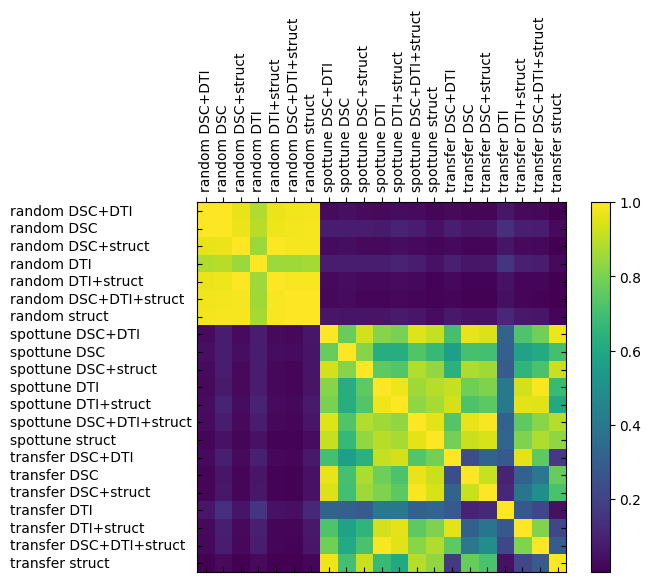

In [157]:
import mpl_toolkits.axisartist as axisartist
figure = plt.figure()
axes = figure.add_subplot(111, axes_class=axisartist.Axes)
caxes = axes.matshow(p_avg_array)
axis_len = np.arange(len(map_keys))
axes.set_xticks(axis_len)
axes.set_yticks(axis_len)
axes.set_xticklabels(x_map_keys)
axes.set_yticklabels(y_map_keys)
axes.axis['bottom'].toggle(ticklabels=False)
axes.axis['top'].toggle(ticklabels=True)
axes.axis["left"].major_ticklabels.set_ha("left")
axes.axis['top'].set_axis_direction('right')
axes.axis['top'].major_ticklabels.set_rotation(90)
axes.axis['top'].major_ticklabels.set_pad(-8)
#axes.axis["top"].major_ticklabels.set_ha("left")
figure.colorbar(caxes)
#plt.tight_layout()
plt.show()
figure.savefig('p_value_map.png', bbox_inches='tight')